# **Infrastructure object recognition using satellite data**

In [2]:
import torch
import torch.nn as nn
import cv2 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from src.calculate_metrics import F1
import segmentation_models_pytorch as smp

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

## **Intersecting tiles with vote aggregation**

Smart image cutting into Tiles with controlled overlay.

In [3]:
# Thanks to https://github.com/Devyanshu/image-split-with-overlap/tree/master

class BatchesFromSingleImageMask:
    def __init__(self, imagefilename, batch_size, maskfilename, kernel_size=(1024, 1024), overlap=0.2, mode='train') -> None:
        """
        Initializes an instance of the BatchesFromSingleImageMask class.

        Args:
            imagefilename (str): Filepath of the input image.
            batch_size (int): Size of each batch.
            maskfilename (str): Filepath of the mask associated with the input image.
            kernel_size (tuple): Size of each image patch (default is (1024, 1024)).
            overlap (float): Percentage of overlap between image patches (0 <= overlap < 1).
            mode (str): Mode of operation ('train', 'test', or 'val').

        Returns:
            None
        """

        self.imagefilename = imagefilename
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.mode = mode

        ####################################
        # Augmentation here
        self.train_transform = A.Compose([
        
            A.OneOf(
                [
                    A.VerticalFlip(p=1),
                    A.HorizontalFlip(p=1),
                    A.RandomRotate90(p=1),
                    A.Transpose(p=1),
                ],
                p=0.5,
            ),
            ToTensorV2()
        ])
        #
        ####################################
        
        big_image = cv2.imread(imagefilename, cv2.IMREAD_COLOR)
        big_image = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)
        
        if self.mode == 'train' or self.mode == 'val':
            big_mask = cv2.imread(maskfilename, cv2.IMREAD_GRAYSCALE)
            assert big_image.shape[0] == big_mask.shape[0] and big_image.shape[1] == big_mask.shape[1], "Image and mask shapes do not match"
            # Transform
            big_image, big_mask = self._transform(big_image, big_mask)
            
            self.masks = list(self._split_image(big_mask, kernel_size, overlap, is_mask=True))
            self.big_mask = big_mask.to(device)
        elif self.mode == 'test':
            big_image = torch.from_numpy(big_image).permute(2, 0, 1)
            big_image = big_image / 255.0
            
        self.orig_shape = big_image.shape[1:]
        self.big_image = big_image.to(device)
        self.images = list(self._split_image(big_image, kernel_size, overlap))
        self.generate_batches()

    def _transform(self, image, mask):

        """
        Applies data augmentation to the input image and mask.

        Args:
            image (numpy.ndarray): Input image.
            mask (numpy.ndarray): Input mask.

        Returns:
            tuple: Augmented image and mask.
        """

        self.transform = A.Compose([
                # A.RandomRotate90(p=0.5),
                ToTensorV2()
            ])
        
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image'].float() / 255.0
        mask = augmented['mask']
        return image, mask
    
    def _split_image(self, big_image: torch.Tensor, desired_size: tuple=(512, 512), overlap=0.5, is_mask=False):
        """
            Generates the patches of smaller sizes from the big image.
            
        Args:
            big_image (tensor): An image with size bigger the desired size
            desired_size (tuple(int, int)): Desired size of the patches
            overlap (0 <= float < 1): the precentage of image to be overlapped
            is_mask (bool): Different behaviour for mask
        Returns:
            generator: Generator of ImageContainer objeects
        """
        if is_mask:
            big_image = big_image[None, :, :]
        img_c, img_h, img_w, = big_image.shape
        split_width, split_height = desired_size

        def start_points(size, split_size, overlap=0):
            points = [0]
            stride = int(split_size * (1-overlap))
            counter = 1
            while True:
                pt = stride * counter
                if pt + split_size >= size:
                    if split_size == size:
                        break
                    points.append(size - split_size)
                    break
                else:
                    points.append(pt)
                counter += 1
            return points

        X_points = start_points(img_w, split_width, overlap)
        Y_points = start_points(img_h, split_height, overlap)

        for i in Y_points:
            for j in X_points:
                yield (i, j)
    
    def generate_batches(self):
        """
        Generates batches of image and mask pairs based on the specified mode.

        Returns:
            list: List of batches.
        """
        self.batches = []
        if self.mode == 'train':
            # Train mode
            for i in range(0, len(self.images), self.batch_size)[:-1]:
                image_stack, mask_stack = [], []
                for j in range(self.batch_size):
                    image_slice = self._get_image_slice(self.images[i + j]).permute(1, 2, 0).cpu().numpy()
                    mask_slice = self._get_mask_slice(self.images[i + j]).cpu().numpy()

                    augmented = self.train_transform(image=image_slice, mask=mask_slice)
                    image = augmented['image']
                    mask = augmented['mask']

                    image_stack.append(image)
                    mask_stack.append(mask)
                self.batches.append([
                    torch.stack(image_stack),
                    torch.stack(mask_stack)
                ])
            image_stack, mask_stack = [], []
            for j in range(self.batch_size):
                image_slice = self._get_image_slice(self.images[len(self.images) - self.batch_size + j]).permute(1, 2, 0).cpu().numpy()
                mask_slice = self._get_mask_slice(self.images[len(self.masks) - self.batch_size + j]).cpu().numpy()
                
                augmented = self.train_transform(image=image_slice, mask=mask_slice)
                image = augmented['image']
                mask = augmented['mask']

                image_stack.append(image)
                mask_stack.append(mask)
            self.batches.append([
                torch.stack(image_stack),
                torch.stack(mask_stack)
            ])
        elif self.mode == 'test':
            # Test mode
            for i in range(0, len(self.images), self.batch_size)[:-1]:
                self.batches.append(
                    torch.stack(tuple(self._get_image_slice(self.images[i + j]) for j in range(self.batch_size)))
                )
            self.batches.append(
                torch.stack(tuple(self._get_image_slice(self.images[len(self.images) - self.batch_size + j]) for j in range(self.batch_size)))
            )
        else:
            # Val mode
            for i in range(0, len(self.images), self.batch_size)[:-1]:
                self.batches.append(
                    (torch.stack(tuple(self._get_image_slice(self.images[i + j]) for j in range(self.batch_size))),
                    torch.stack(tuple(self._get_mask_slice(self.masks[i + j]) for j in range(self.batch_size))))
                )
            self.batches.append(
                (torch.stack(tuple(self._get_image_slice(self.images[len(self.images) - self.batch_size + j]) for j in range(self.batch_size))),
                torch.stack(tuple(self._get_mask_slice(self.masks[len(self.masks) - self.batch_size + j]) for j in range(self.batch_size))))
            )
        return self.batches

    def _get_image_slice(self, pos):
        """
        Extracts a slice of the input image based on the specified position.

        Args:
            pos (tuple): Position (y, x) of the image slice.

        Returns:
            torch.Tensor: Image slice.
        """
        posy, posx = pos
        dh, dw = self.kernel_size
        return self.big_image[:, posy:posy+dh, posx:posx+dw]

    def _get_mask_slice(self, pos):
        """
        Extracts a slice of the input mask based on the specified position.

        Args:
            pos (tuple): Position (y, x) of the mask slice.

        Returns:
            torch.Tensor: Mask slice.
        """
        posy, posx = pos
        dh, dw = self.kernel_size
        return self.big_mask[posy:posy+dh, posx:posx+dw]
    
    def __getitem__(self, idx):
        """
        Retrieves a batch based on the specified index.

        Args:
            idx (int): Index of the batch.

        Returns:
            list: Batch containing image and mask pairs.
        """
        return self.batches[idx]
    
    def __len__(self):
        """
        Returns the number of batches.

        Returns:
            int: Number of batches.
        """
        return len(self.batches)

    def merge_masks(self, masks):
        """
        Merges multiple masks into a single mask.

        Args:
            masks (list): List of masks to be merged.

        Returns:
            torch.Tensor: Merged mask.
        """
        answer = torch.zeros(size=(2, *self.orig_shape)).to(device)
        counter = torch.zeros(size=(2, *self.orig_shape)).to(device)
        k = 0
        for batch in masks[:-1]:
            for mask in batch:
                posy, posx = self.images[k]
                dh, dw = self.kernel_size
                answer[:, posy: posy + dh, posx: posx + dw] += mask
                counter[:, posy: posy + dh, posx: posx + dw] += 1
                k += 1
        k = len(self.images) - self.batch_size
        for mask in masks[-1]:
            posy, posx = self.images[k]
            dh, dw = self.kernel_size
            answer[:, posy: posy + dh, posx: posx + dw] += mask
            counter[:, posy: posy + dh, posx: posx + dw] += 1
            k += 1
        answer = answer / counter
        answer = torch.argmax(answer, dim = 0, keepdims=True)
        # Convert to HWC
        answer = answer.permute(1, 2, 0)
        return answer

## **Train / Validation split**

In [4]:
import random

seed_value = 42
random.seed(seed_value)

filenames = [(f"train/images/train_image_{i:03d}.png", f"train/masks/train_mask_{i:03d}.png") for i in range(21)]
random.shuffle(filenames)

train_size = int(0.8 * len(filenames))

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]


## **Model**
Creating an EnsembleModel with two U-Net++ models

Model 1: U-Net++ with 'resnet50' backbone
  - pretrained on 'imagenet'
  - no activation function (raw logits)
  - 2 output classes
  - encoder depth of 5
  - decoder channels: [256, 128, 64, 32, 16]

Model 2: U-Net++ with 'efficientnet-b7' backbone
  - pretrained on 'imagenet'
  - no activation function (raw logits)
  - 2 output classes
  - encoder depth of 5
  - decoder channels: [256, 128, 64, 32, 16]

In [5]:
from src.ensemble import EnsembleModel

model = EnsembleModel([
    smp.UnetPlusPlus('resnet50', encoder_weights='imagenet', activation=None, classes = 2, encoder_depth= 5, decoder_channels=[256, 128, 64, 32, 16]),
    smp.UnetPlusPlus('efficientnet-b7', encoder_weights='imagenet', activation=None, classes = 2, encoder_depth= 5, decoder_channels=[256, 128, 64, 32, 16])
])

model = model.to(device)

## **Train**

In [6]:
from src.DiceLoss import DiceLoss

optimizer = torch.optim.Adam(
    model.parameters(),
)

epochs = 30
optimizer = torch.optim.Adam(model.parameters())

criterion1 = nn.CrossEntropyLoss(reduction="mean")
criterion2 = DiceLoss()

In [7]:
history = {
    'train_loss': [],
    'val_loss': [],
    'F1 score': [],
}

def train_model(model, train_filenames, val_filenames, device, optimizer, epochs=1, batch_size=2):
    best_score = 0
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        loss_len = 0
        with tqdm(
            desc=f"Epoch {epoch}/{epochs}", unit="img"
        ) as pbar:
            for im, mk in train_filenames:
                train_loader = BatchesFromSingleImageMask(im, batch_size, mk, mode='train')
                for i, batch in enumerate(train_loader):
                    images, true_masks = batch
        
                    images, true_masks = images.to(device), true_masks.to(device)
                    true_masks = true_masks.squeeze(dim=1)
                    
                    masks_pred = model(images)
                    loss = criterion1(masks_pred, true_masks.long()) + criterion2(masks_pred, true_masks)
                    epoch_loss += loss.item()
                    loss_len += 1
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    pbar.update(images.shape[0])
                    pbar.set_description(f"Epoch: {epoch}, train_loss: {epoch_loss / (loss_len)}")

                del train_loader
                gc.collect()
            history['train_loss'].append(epoch_loss)
            
                
        model.eval()
        f1_metrics = np.array([])
        epoch_loss = 0
        loss_len = 0
        
        with tqdm(desc=f"Validation", unit="img") as pbar:
            with torch.no_grad():
                for im, mk in val_filenames:
                    val_loader = BatchesFromSingleImageMask(im, batch_size, mk, mode='val')
        
                    predictions_batches = []
                    
                    
                    for i, batch in enumerate(val_loader):
                        images, true_masks = batch
        
                        images, true_masks = images.to(device), true_masks.to(device)
                        true_masks = true_masks.squeeze(dim=1)
                        
                        masks_pred = model(images)
                        
                        loss = criterion1(masks_pred, true_masks.long()) + criterion2(masks_pred, true_masks)
                        epoch_loss += loss.item()
                        loss_len += 1
                        
                        predictions_batches.append(masks_pred)
                        
                        pbar.update(images.shape[0])
                        pbar.set_description(f"val_loss: {epoch_loss / (loss_len)}")
                    
                    pred_full = val_loader.merge_masks(predictions_batches).permute(2, 0, 1)
                    true_full = val_loader.big_mask[None,:,:]
                    
                    f1_metrics = np.append(f1_metrics, F1(true_full, pred_full).cpu().numpy())
                    
        F1_score = f1_metrics.mean()
        print(f'F1 score: {F1_score}')
        history['val_loss'].append(epoch_loss)
        history['F1 score'].append(F1_score)
        
        if F1_score > best_score:
            best_score = F1_score
            torch.save(model.state_dict(), "best_unetplusplus_ensemble.pt")
    return history

In [8]:
history = train_model(model, train_filenames, val_filenames, device, optimizer, epochs=epochs)

Epoch: 1, train_loss: 0.6882905835774963: : 990img [06:47,  2.43img/s]
val_loss: 0.606541684709373: : 320img [00:38,  8.37img/s] 


F1 score: 0.5679290592670441


Epoch: 2, train_loss: 0.5587540461296084: : 990img [07:04,  2.33img/s]
val_loss: 0.5304873357858014: : 320img [00:38,  8.34img/s] 


F1 score: 0.628374433517456


Epoch: 3, train_loss: 0.5058067934013752: : 990img [06:40,  2.47img/s] 
val_loss: 0.5643281044045579: : 320img [00:37,  8.65img/s] 


F1 score: 0.5889375567436218


Epoch: 4, train_loss: 0.4738956952439339: : 990img [06:28,  2.55img/s] 
val_loss: 0.5198419503569311: : 320img [00:37,  8.42img/s] 


F1 score: 0.6086065649986268


Epoch: 5, train_loss: 0.4649295512483352: : 990img [06:30,  2.53img/s] 
val_loss: 0.4965428570916629: : 320img [00:37,  8.44img/s] 


F1 score: 0.6323824882507324


Epoch: 6, train_loss: 0.4356533020203275: : 990img [06:36,  2.50img/s] 
val_loss: 0.5232323742726294: : 320img [00:37,  8.45img/s] 


F1 score: 0.5944790065288543


Epoch: 7, train_loss: 0.42584239118309186: : 990img [06:32,  2.52img/s]
val_loss: 0.4999337378805649: : 320img [00:39,  8.16img/s] 


F1 score: 0.6221292853355408


Epoch: 8, train_loss: 0.4134891376781249: : 990img [06:26,  2.56img/s] 
val_loss: 0.5197943367420521: : 320img [00:38,  8.33img/s] 


F1 score: 0.5996833741664886


Epoch: 9, train_loss: 0.3985140827216321: : 990img [06:29,  2.54img/s] 
val_loss: 0.48328468794916263: : 320img [00:37,  8.57img/s]


F1 score: 0.6413819968700409


Epoch: 10, train_loss: 0.38799427925924196: : 990img [06:33,  2.52img/s]
val_loss: 0.5179565865139011: : 320img [00:39,  8.03img/s] 


F1 score: 0.5976580381393433


Epoch: 11, train_loss: 0.3821788575314456: : 990img [06:26,  2.56img/s] 
val_loss: 0.4984022482480214: : 320img [00:38,  8.29img/s] 


F1 score: 0.6133952915668488


Epoch: 12, train_loss: 0.3773578780680904: : 990img [06:32,  2.52img/s] 
val_loss: 0.4793238894475508: : 320img [00:39,  8.11img/s] 


F1 score: 0.653177797794342


Epoch: 13, train_loss: 0.36349499670146596: : 990img [06:28,  2.55img/s]
val_loss: 0.47842920513357967: : 320img [00:38,  8.41img/s]


F1 score: 0.6474604725837707


Epoch: 14, train_loss: 0.3566798657634545: : 990img [06:26,  2.56img/s] 
val_loss: 0.4734068131121603: : 320img [00:38,  8.27img/s] 


F1 score: 0.6496530473232269


Epoch: 15, train_loss: 0.36073310652611346: : 990img [06:25,  2.57img/s]
val_loss: 0.4741500841997549: : 320img [00:37,  8.61img/s] 


F1 score: 0.6406899452209472


Epoch: 16, train_loss: 0.3575632401188186: : 990img [06:21,  2.59img/s] 
val_loss: 0.4620364788273946: : 320img [00:37,  8.44img/s] 


F1 score: 0.6751301288604736


Epoch: 17, train_loss: 0.34487339909343667: : 990img [06:26,  2.56img/s]
val_loss: 0.47633795775691395: : 320img [00:37,  8.60img/s]


F1 score: 0.6390000283718109


Epoch: 18, train_loss: 0.3493386948496783: : 990img [06:32,  2.52img/s] 
val_loss: 0.49706369961922975: : 320img [00:38,  8.32img/s]


F1 score: 0.6251762092113495


Epoch: 19, train_loss: 0.3703317877701883: : 990img [06:31,  2.53img/s] 
val_loss: 0.47468332023645415: : 320img [00:36,  8.74img/s]


F1 score: 0.6329201102256775


Epoch: 20, train_loss: 0.33427898931167693: : 990img [06:33,  2.52img/s]
val_loss: 0.47806369029005963: : 320img [00:39,  8.15img/s]


F1 score: 0.6390278220176697


Epoch: 21, train_loss: 0.32521690155471783: : 990img [06:24,  2.58img/s]
val_loss: 0.4811975087803148: : 320img [00:36,  8.73img/s] 


F1 score: 0.6387229025363922


Epoch: 22, train_loss: 0.31726477956616866: : 990img [06:22,  2.59img/s]
val_loss: 0.4728074350350653: : 320img [00:40,  8.00img/s] 


F1 score: 0.6523137211799621


Epoch: 23, train_loss: 0.3125051067286874: : 990img [06:20,  2.60img/s] 
val_loss: 0.47214195628403105: : 320img [00:37,  8.61img/s]


F1 score: 0.6437747359275818


Epoch: 24, train_loss: 0.3193789739107638: : 990img [06:18,  2.62img/s] 
val_loss: 0.5092589639798462: : 320img [00:36,  8.72img/s] 


F1 score: 0.6026652991771698


Epoch: 25, train_loss: 0.317013299642948: : 990img [06:16,  2.63img/s]  
val_loss: 0.48057056702728007: : 320img [00:41,  7.76img/s]


F1 score: 0.6305722117424011


Epoch: 26, train_loss: 0.29579644496029367: : 990img [06:24,  2.57img/s]
val_loss: 0.47686129082121625: : 320img [00:36,  8.71img/s]


F1 score: 0.6453683555126191


Epoch: 27, train_loss: 0.2933906232232329: : 990img [06:17,  2.62img/s] 
val_loss: 0.49727900998841507: : 320img [00:37,  8.58img/s]


F1 score: 0.6445564329624176


Epoch: 28, train_loss: 0.32407298021849285: : 990img [06:24,  2.58img/s]
val_loss: 0.48637980670609976: : 320img [00:40,  7.89img/s]


F1 score: 0.6142610728740692


Epoch: 29, train_loss: 0.3085187513404467: : 990img [07:49,  2.11img/s] 
val_loss: 0.49356872092030246: : 320img [00:47,  6.77img/s]


F1 score: 0.6182458221912384


Epoch: 30, train_loss: 0.29117528009298965: : 990img [08:03,  2.05img/s]
val_loss: 0.5095457875766443: : 320img [00:44,  7.23img/s] 

F1 score: 0.6011254638433456


## **Plot**

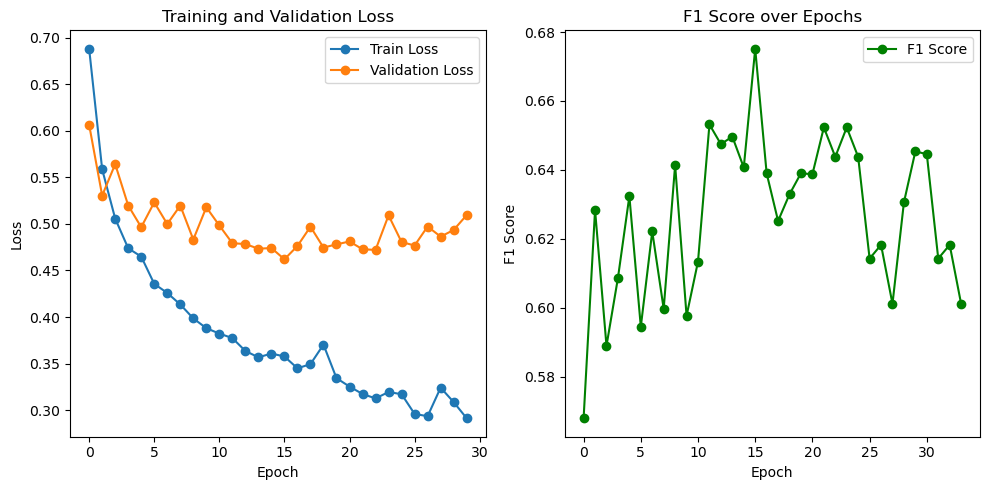

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting F1 score
plt.subplot(1, 2, 2)
plt.plot(history['F1 score'], label='F1 Score', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## **Post-Processing**

The function delete_small_buildings removes small connected components (buildings) from a binary image based on their pixel area, using connected components labeling. 

The min_size parameter specifies the minimum allowed size for a connected component to be retained.

In [52]:
def delete_small_buildings(image, min_size):
    # Find connected components in the image
    _, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)

    # Iterate through connected components and remove small ones
    for i in range(1, stats.shape[0]):  # Skip the background (label 0)
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            image[labels == i] = 0

    return torch.tensor(image).unsqueeze(0)

In [53]:
def validation(min_building_size, batch_size=3):
    model.eval()
    f1_metrics = np.array([])
    
    with tqdm(desc=f"Validation", unit="img") as pbar:
        with torch.no_grad():
            for im, mk in val_filenames:
                val_loader = BatchesFromSingleImageMask(im, batch_size, mk, mode='val')
    
                predictions_batches = []
                
                
                for i, batch in enumerate(val_loader):
                    images, true_masks = batch
    
                    images, true_masks = images.to(device), true_masks.to(device)
                    true_masks = true_masks.squeeze(dim=1)
                    
                    masks_pred = model(images)
                    
                    predictions_batches.append(masks_pred)
                    
                    pbar.update(images.shape[0])
                
                pred_full = val_loader.merge_masks(predictions_batches).permute(2, 0, 1)
                true_full = val_loader.big_mask[None,:,:]
                
                pred_full = delete_small_buildings(pred_full.squeeze(0).cpu().numpy().astype(np.uint8), min_building_size)
                pred_full = pred_full.to(device)
                f1_metrics = np.append(f1_metrics, F1(true_full, pred_full).cpu().numpy())
                
    F1_score = f1_metrics.mean()
    print(f'F1 score: {F1_score}')
    return F1_score

In [54]:
min_building_size = np.linspace(0, 300, num=31, dtype=np.int32)
best_f1_score, best_min_size = 0, 0

for min_size in min_building_size:
    print(f'{min_size=}')
    score = validation(min_size)
    if score > best_f1_score:
        best_f1_score = score
        best_min_size = min_size
print(f'{best_f1_score=}, {best_min_size=}')

min_size=0


Validation: 387img [00:45,  8.49img/s]


F1 score: 0.7006216526031495
min_size=10


Validation: 387img [00:51,  7.46img/s]


F1 score: 0.7006275296211243
min_size=20


Validation: 387img [00:55,  7.01img/s]


F1 score: 0.700641417503357
min_size=30


Validation: 387img [01:03,  6.13img/s]


F1 score: 0.7006716370582581
min_size=40


Validation: 387img [01:05,  5.87img/s]


F1 score: 0.7006911873817444
min_size=50


Validation: 387img [01:14,  5.20img/s]


F1 score: 0.700722336769104
min_size=60


Validation: 387img [01:17,  5.02img/s]


F1 score: 0.7007508873939514
min_size=70


Validation: 387img [01:21,  4.76img/s]


F1 score: 0.7008113622665405
min_size=80


Validation: 387img [01:24,  4.60img/s]


F1 score: 0.700816011428833
min_size=90


Validation: 387img [01:27,  4.45img/s]


F1 score: 0.7008845090866089
min_size=100


Validation: 387img [01:31,  4.21img/s]


F1 score: 0.7009042143821717
min_size=110


Validation: 387img [01:35,  4.06img/s]


F1 score: 0.700953733921051
min_size=120


Validation: 387img [01:34,  4.08img/s]


F1 score: 0.700960659980774
min_size=130


Validation: 387img [01:48,  3.56img/s]


F1 score: 0.7009643316268921
min_size=140


Validation: 387img [01:44,  3.70img/s]


F1 score: 0.7010008454322815
min_size=150


Validation: 387img [02:27,  2.62img/s]


F1 score: 0.7009868860244751
min_size=160


Validation: 387img [02:26,  2.64img/s]


F1 score: 0.7010480523109436
min_size=170


Validation: 387img [02:07,  3.04img/s]


F1 score: 0.7010757207870484
min_size=180


Validation: 387img [02:12,  2.92img/s]


F1 score: 0.7011131286621094
min_size=190


Validation: 387img [01:53,  3.41img/s]


F1 score: 0.7012294650077819
min_size=200


Validation: 387img [01:56,  3.32img/s]


F1 score: 0.7013792276382447
min_size=210


Validation: 387img [02:00,  3.20img/s]


F1 score: 0.7014265656471252
min_size=220


Validation: 387img [02:12,  2.91img/s]


F1 score: 0.7014810919761658
min_size=230


Validation: 387img [02:13,  2.89img/s]


F1 score: 0.7014584422111512
min_size=240


Validation: 387img [02:11,  2.93img/s]


F1 score: 0.7015440702438355
min_size=250


Validation: 387img [02:20,  2.76img/s]


F1 score: 0.701536238193512
min_size=260


Validation: 387img [02:12,  2.92img/s]


F1 score: 0.7014490246772767
min_size=270


Validation: 387img [02:17,  2.81img/s]


F1 score: 0.7013948440551758
min_size=280


Validation: 387img [02:19,  2.78img/s]


F1 score: 0.7013757228851318
min_size=290


Validation: 387img [02:32,  2.54img/s]


F1 score: 0.7012992620468139
min_size=300


Validation: 387img [02:21,  2.74img/s]

F1 score: 0.7012162923812866
best_f1_score=0.7015440702438355, best_min_size=240


## **Inference**
*Uncomment if you are using our checkpoint*

In [ ]:
# model = EnsembleModel([
#     smp.UnetPlusPlus('resnet50', encoder_weights='imagenet', classes = 2, activation=None, encoder_depth= 5, decoder_channels=[256, 128, 64, 32, 16]),
#     smp.UnetPlusPlus('efficientnet-b7', encoder_weights='imagenet', classes = 2, activation=None, encoder_depth= 5, decoder_channels=[256, 128, 64, 32, 16]),
# ])
# model = model.to(device)
# model.load_state_dict(torch.load('best_unetplusplus_ensemble.pt'))

In [ ]:
model.eval()
batch_size = 1
test_filenames = [f"test/images/test_image_{i:03d}.png" for i in range(21)]

with tqdm(desc=f"Inference", unit="img") as pbar:
    with torch.no_grad():
        for j, im in enumerate(test_filenames):
            test_loader = BatchesFromSingleImageMask(im, batch_size, None, test_mode=True)
            
            predictions_batches = []
            
            for i, images in enumerate(test_loader.generate_batches()):
                images = images.to(device)
                masks_pred = model(images)

                pred = torch.argmax(masks_pred, dim=1)
            
                predictions_batches.append(masks_pred)
                
                pbar.update(images.shape[0])
            pred_full = test_loader.merge_masks(predictions_batches).permute(2, 0, 1)
            np_pred_full = pred_full.squeeze(0).cpu().numpy()
            plt.imsave(f'test/masks/test_image_{j:03d}.png', np_pred_full)
            

In [ ]:
def plot_result(original_image, prediction_mask, true_mask):
    original_image = cv2.imread(original_image, cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    prediction_mask = prediction_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    
    fig = plt.figure()
    plt.imshow(original_image)
    plt.imshow(true_mask, alpha=0.6)
    plt.title('Original mask')
    plt.show()
    # fig.savefig('figure_real.png', dpi=500, bbox_inches='tight')

    fig = plt.figure()
    plt.imshow(original_image)
    plt.imshow(prediction_mask, alpha=0.6)
    plt.title('Prediction mask')
    plt.show()
    # fig.savefig('figure_predicted.png', dpi=500, bbox_inches='tight')